In [1]:
import numpy as np
from numpy import nan
import pandas as pd
import s3fs
import snowflake.connector
from datetime import date, timedelta, datetime
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.preprocessing import OneHotEncoder
import statistics
import multiprocessing
from sf import sf_connection
import logging
import snowflake.connector
import pyarrow
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import boto3
import warnings
import pyarrow.parquet as pq
import s3fs
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import statsmodels.api as sm
from IPython.core.display import display, HTML
s3 = s3fs.S3FileSystem()
warnings.filterwarnings('ignore')

/usr/local/lib64/python3.7/site-packages/snowflake/connector/options.py:97: UserWarning: You have an incompatible version of 'pyarrow' installed (7.0.0), please install a version that adheres to: 'pyarrow<6.1.0,>=6.0.0; extra == "pandas"'
  _expected_pyarrow_version,


In [289]:
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display
%matplotlib inline

In [3]:
conn = sf_connection()

### First read in Min's email test table augmented with discount sensitivity scores

In [4]:
email_test_data = pd.read_sql('select * from MC_DSTEST_AUGMENTED', conn)

In [5]:
len(email_test_data)

7564497

In [6]:
email_test_data.head()

EMAIL_ADDRESS      SEND_DATE             DISCOUNT  \
0  007nieves@gmail.com  SATURDAY_0115                0.100   
1  0082590gv@gmail.com  SATURDAY_0115                0.200   
2  03271991d@gmail.com  THURSDAY_0113                0.100   
3  03271991d@gmail.com  SATURDAY_0115                0.100   
4  03cowgurl@gmail.com  SATURDAY_0115                0.200   

                 SCORE SENSITIVITY  
0                0.356         LOW  
1                0.007         LOW  
2                0.004         LOW  
3                0.004         LOW  
4                0.020         LOW

### Now we create categories (since we want to do groupby)

In [7]:
email_test_data['DISCOUNT_CAT'] = pd.cut(email_test_data.DISCOUNT,
                 [0.0, 0.11, 0.16, 0.21, np.inf],
                 labels=['10%','15%','20%', '25%'])

In [8]:
email_test_data.head(20)

EMAIL_ADDRESS      SEND_DATE             DISCOUNT  \
0          007nieves@gmail.com  SATURDAY_0115                0.100   
1          0082590gv@gmail.com  SATURDAY_0115                0.200   
2          03271991d@gmail.com  THURSDAY_0113                0.100   
3          03271991d@gmail.com  SATURDAY_0115                0.100   
4          03cowgurl@gmail.com  SATURDAY_0115                0.200   
5    03gozalojuarez1@gmail.com  THURSDAY_0113                0.100   
6    03gozalojuarez1@gmail.com  SATURDAY_0115                0.100   
7       03mcolindres@gmail.com  THURSDAY_0113                0.100   
8       03mcolindres@gmail.com  SATURDAY_0115                0.100   
9       05fordharley@gmail.com  SATURDAY_0115                0.100   
10     0604mark.hall@gmail.com  SATURDAY_0115                0.150   
11        0785victor@gmail.com  SATURDAY_0115                0.100   
12       07ryanmeeks@gmail.com  THURSDAY_0113                0.150   
13       07ryanmeeks@gmail.com  SATURDAY_0115                0.150   
14  0924jorgealvarez@gmail.com  SATURDAY_0115                0.200   
15       1019950bear@gmail.com  SATURDAY_0115                0.150   
16       1019950bear@gmail.com  THURSDAY_0113                0.150   
17            1031ar@gmail.com  SATURDAY_0115                0.150   
18            1031ar@gmail.com  THURSDAY_0113                0.150   
19       103vinelane@gmail.com  THURSDAY_0113                0.100   

                  SCORE SENSITIVITY DISCOUNT_CAT  
0                 0.356         LOW          10%  
1                 0.007         LOW          20%  
2                 0.004         LOW          10%  
3                 0.004         LOW          10%  
4                 0.020         LOW          20%  
5                 0.001         LOW          10%  
6                 0.001         LOW          10%  
7                 0.012         LOW          10%  
8                 0.012         LOW          10%  
9                 0.022         LOW          10%  
10                0.025         LOW          15%  
11                0.019         LOW          10%  
12                0.015         LOW          15%  
13                0.015         LOW          15%  
14                0.070         LOW          20%  
15                0.020         LOW          15%  
16                0.020         LOW          15%  
17                0.013         LOW          15%  
18                0.013         LOW          15%  
19                0.025         LOW          10%

### Now we read in the email cross reference table

In [9]:
EMAIL_XREF_QUERY = """
    select 
        INDV_ID, 
        EMAIL
    from
    (select 
        INDV_ID, 
        EMAIL,
        row_number() over (partition by EMAIL order by INDV_ID desc) as ROWNUM
    from CUST_UNIFIED_IDENTITY_PT_V) 
    where ROWNUM = 1 and INDV_ID is not null"""

In [10]:
email_xref = pd.read_sql(EMAIL_XREF_QUERY, conn)

In [11]:
len(email_xref)

40500031

In [12]:
email_xref.head()

INDV_ID                     EMAIL
0  624850335           klyde45@aol.com
1  115548544      blazinblu4@gmail.com
2  582489711  lisenhour2pghs@gmail.com
3  583589528    rickydwhite0@gmail.com
4  602050985       jimschink@gmail.com

In [13]:
email_xref['EMAIL'].nunique()

40500030

In [14]:
email_xref['INDV_ID'].nunique()

39772578

### Each email can have multiple INDV_IDs

In [15]:
email_xref.isna().sum()

INDV_ID    0
EMAIL      1
dtype: int64

In [16]:
email_xref.dropna(inplace=True)

In [17]:
email_xref.isna().sum()

INDV_ID    0
EMAIL      0
dtype: int64

In [18]:
email_xref['INDV_ID'].nunique()

39772577

In [19]:
email_xref['EMAIL'].nunique()

40500030

In [20]:
len(email_xref)

40500030

In [21]:
40456543 - 39730202

726341

### 726K indv_ids are assigned to multiple email addresses.  To avoid double counting reveneue, we're going to delete duplicate indv_id.  This analysis will only focus on counting email addresses

In [22]:
email_xref.drop_duplicates(['INDV_ID'], inplace=True)

In [23]:
email_xref['INDV_ID'].nunique()

39772577

In [24]:
email_xref['EMAIL'].nunique()

39772577

### We now have a one-to-one relationship. We inner join the email cross-reference to the test data, enabling each email address to link to FITS via INDV_ID

In [25]:
email_xref.rename(columns={'EMAIL': 'EMAIL_ADDRESS'}, inplace=True)

In [26]:
email_test_indv_xref = pd.merge(email_test_data, email_xref, on='EMAIL_ADDRESS', how='inner')

In [27]:
len(email_test_indv_xref), len(email_test_data) - len(email_test_indv_xref)

(7338271, 226226)

### We lost 226K email sends since these didn't have INDV_IDs.   We have changed our strategy to count email adresses (instead of sends). Each email in the list had at lease one email send.  We now delete duplicate emails.

In [28]:
email_test_indv_xref['EMAIL_ADDRESS'].nunique()

4237860

In [29]:
email_test_indv_xref['INDV_ID'].nunique()

4237860

In [30]:
email_test_indv_xref.isna().sum()

EMAIL_ADDRESS    0
SEND_DATE        0
DISCOUNT         0
SCORE            0
SENSITIVITY      0
DISCOUNT_CAT     0
INDV_ID          0
dtype: int64

### Now since we will be counting things by email address instead of sends, we need to eliminate duplicate email address.  We want to end up with a one to one relationship with email address and INDV_ID

In [31]:
email_test_indv_xref.drop_duplicates(['EMAIL_ADDRESS'], inplace=True)

In [32]:
len(email_test_indv_xref)

4237860

### No duplicates

### We have a total of 4.2M email addresses that we will use for our analyais.  Each of these email addresses has a single indv_id for joining to fits

In [33]:
email_test_indv_xref.head()

EMAIL_ADDRESS      SEND_DATE             DISCOUNT  \
0        007nieves@gmail.com  SATURDAY_0115                0.100   
1        0082590gv@gmail.com  SATURDAY_0115                0.200   
2        03271991d@gmail.com  THURSDAY_0113                0.100   
4        03cowgurl@gmail.com  SATURDAY_0115                0.200   
5  03gozalojuarez1@gmail.com  THURSDAY_0113                0.100   

                 SCORE SENSITIVITY DISCOUNT_CAT    INDV_ID  
0                0.356         LOW          10%  651967247  
1                0.007         LOW          20%  637189310  
2                0.004         LOW          10%  604900358  
4                0.020         LOW          20%  542951874  
5                0.001         LOW          10%  231100332

email_test_indv_xref.to_csv('s3://aap-aiexpzone-pii-mktg-datascientist-results-prod/ScottSmith/discount_preference/email_test_indv_xref.csv', index=False, header=True)

### To look at the full revenue and margin for each of these customers, we will include return only transactions in FITS.  These will be deleted when we model to keep observations stricly positive

In [34]:
FITS_QUERY = """
    select
        TRAN_DATE, 
        POS_GROSS_SALES_AMOUNT, 
        POS_SALES_WO_DISCOUNT, 
        POS_QUANTITY_SOLD, 
        POS_COST_OF_GOODS_SOLD, 
        POS_GROSS_MARGIN, 
        POS_GROSS_RETURNS_AMOUNT, 
        COUPON_DISCOUNT_PRORATION_AMT, 
        TRANSACTION_IDENTIFIER, 
        SEQ_NUMBER,
        SALES_CHANNEL_IDENTIFIER
    from PEDW.SALES_PROTECTED.FACT_ITEM_TRANSACTION_SALES_V
    where TRAN_DATE between '2022-01-13' and '2022-01-20'
    and SALES_CHANNEL_IDENTIFIER in (3)  """

In [35]:
fits = pd.read_sql(FITS_QUERY, conn)

In [36]:
len(fits)

150532

In [37]:
fits.head()

TRAN_DATE  POS_GROSS_SALES_AMOUNT  POS_SALES_WO_DISCOUNT  \
0  2022-01-13                  34.490                 34.490   
1  2022-01-13                  16.050                 20.790   
2  2022-01-13                  26.990                 26.990   
3  2022-01-13                  13.990                 13.990   
4  2022-01-13                   7.490                  7.490   

   POS_QUANTITY_SOLD  POS_COST_OF_GOODS_SOLD     POS_GROSS_MARGIN  \
0                  1                   4.360               30.130   
1                  1                  10.930                5.120   
2                  1                  10.780               16.210   
3                  1                   4.750                9.240   
4                  1                   1.800                5.690   

   POS_GROSS_RETURNS_AMOUNT  COUPON_DISCOUNT_PRORATION_AMT  \
0                     0.000                          0.000   
1                     0.000                          0.000   
2                     0.000                          5.470   
3                     0.000                          0.000   
4                     0.000                          0.000   

              TRANSACTION_IDENTIFIER  SEQ_NUMBER  SALES_CHANNEL_IDENTIFIER  
0   0000102000001000000433820220113.           3                         3  
1   0000102000001000000005520220113.           1                         3  
2   0000102000001000000184220220113.           1                         3  
3   0000102000001000000689520220113.           1                         3  
4   0000102000001000000607620220113.           4                         3

In [38]:
fits['TRANSACTION_IDENTIFIER'].nunique()

91653

In [39]:
fits[['POS_GROSS_SALES_AMOUNT', 'POS_GROSS_RETURNS_AMOUNT', 'POS_GROSS_MARGIN']].sum()

POS_GROSS_SALES_AMOUNT            5,895,335.660
POS_GROSS_RETURNS_AMOUNT            801,203.660
POS_GROSS_MARGIN                  3,045,207.030
dtype: float64

In [40]:
5895335.660 - 801203.660

5094132.0

In [41]:
5094132.0/91653

55.58063565840725

In [42]:
3045207.030/5094132.0

0.5977872245948868

### Net revenue for channel 3 during the selected week was 5.1M, with gross margin of 0.60

### There were 92K transactions made during this period in channel 3 with a total of 151K line items.  AOV was 56 dollars

### Now we join FITS to FITS_EXTN to get INDV_IDs

In [43]:
FITS_EXTN_QUERY = """
    select 
        TRANSACTION_ID as TRANSACTION_IDENTIFIER, 
        SEQ_NUMBER, 
        INDV_ID, 
        TRAN_DATE 
    from PEDW.SALES_PROTECTED.FACT_ITEM_TRANSACTION_SALES_EXTN_V
    where TRAN_DATE between '2022-01-13' and '2022-01-20' """

In [44]:
fits_extn = pd.read_sql(FITS_EXTN_QUERY, conn)

In [45]:
len(fits_extn)

6349099

In [46]:
fits_complete = pd.merge(fits, fits_extn, on=['TRANSACTION_IDENTIFIER', 'SEQ_NUMBER'], how='inner')

In [47]:
len(fits_complete)

150532

In [48]:
fits_complete.drop_duplicates(subset=['TRANSACTION_IDENTIFIER', 'SEQ_NUMBER'], inplace=True)

In [49]:
len(fits_complete)

150532

### We have now added INDV_ID to the FITS table, so we can join to the email test data

### We can only track customers with INDV_IDs so we need to remove transactions without INDV_IDs

In [50]:
fits_complete['INDV_ID'].isna().sum()

299

In [51]:
fits_complete.dropna(subset=['INDV_ID'], inplace=True)

In [52]:
len(fits_complete)

150233

In [53]:
len(fits_complete[fits_complete.INDV_ID <= 0])

0

In [54]:
fits_complete = fits_complete[fits_complete.INDV_ID > 0].copy()

In [55]:
len(fits_complete)

150233

In [56]:
email_test_indv_xref.head()

EMAIL_ADDRESS      SEND_DATE             DISCOUNT  \
0        007nieves@gmail.com  SATURDAY_0115                0.100   
1        0082590gv@gmail.com  SATURDAY_0115                0.200   
2        03271991d@gmail.com  THURSDAY_0113                0.100   
4        03cowgurl@gmail.com  SATURDAY_0115                0.200   
5  03gozalojuarez1@gmail.com  THURSDAY_0113                0.100   

                 SCORE SENSITIVITY DISCOUNT_CAT    INDV_ID  
0                0.356         LOW          10%  651967247  
1                0.007         LOW          20%  637189310  
2                0.004         LOW          10%  604900358  
4                0.020         LOW          20%  542951874  
5                0.001         LOW          10%  231100332

In [57]:
len(email_test_indv_xref)

4237860

In [58]:
import matplotlib

### All data is now imported

### We will use the email test data as our left table, and  join with FITS on INDV_ID

In [59]:
test_indv = pd.merge(email_test_indv_xref, fits_complete, on='INDV_ID', how='left')

In [60]:
len(test_indv)

4266463

### Note that the size of test_indv is greater than email_test_indv_xref since each indv id can have multiple FITs transaction lines

In [61]:
test_indv['INDV_ID'].isna().sum()

0

In [62]:
test_indv['EMAIL_ADDRESS'].nunique()

4237860

In [63]:
test_indv['POS_GROSS_SALES_AMOUNT'].isna().sum()

4215573

In [64]:
4237970 - 4215673

22297

### Most of the email addresses didn't have any FITS transaction.   Only 22K transaction rows remain.  Note this is higer than the number of emails that remain since an email could have multiple transaction lines.

In [65]:
len(test_indv)

4266463

In [66]:
test_indv.dtypes

EMAIL_ADDRESS                      object
SEND_DATE                          object
DISCOUNT                          float64
SCORE                             float64
SENSITIVITY                        object
DISCOUNT_CAT                     category
INDV_ID                             int64
TRAN_DATE_x                        object
POS_GROSS_SALES_AMOUNT            float64
POS_SALES_WO_DISCOUNT             float64
POS_QUANTITY_SOLD                 float64
POS_COST_OF_GOODS_SOLD            float64
POS_GROSS_MARGIN                  float64
POS_GROSS_RETURNS_AMOUNT          float64
COUPON_DISCOUNT_PRORATION_AMT     float64
TRANSACTION_IDENTIFIER             object
SEQ_NUMBER                        float64
SALES_CHANNEL_IDENTIFIER          float64
TRAN_DATE_y                        object
dtype: object

In [67]:
test_indv.isna().sum()

EMAIL_ADDRESS                          0
SEND_DATE                              0
DISCOUNT                               0
SCORE                                  0
SENSITIVITY                            0
DISCOUNT_CAT                           0
INDV_ID                                0
TRAN_DATE_x                      4215573
POS_GROSS_SALES_AMOUNT           4215573
POS_SALES_WO_DISCOUNT            4215573
POS_QUANTITY_SOLD                4215573
POS_COST_OF_GOODS_SOLD           4215573
POS_GROSS_MARGIN                 4215573
POS_GROSS_RETURNS_AMOUNT         4215573
COUPON_DISCOUNT_PRORATION_AMT    4215573
TRANSACTION_IDENTIFIER           4215573
SEQ_NUMBER                       4215573
SALES_CHANNEL_IDENTIFIER         4215573
TRAN_DATE_y                      4215573
dtype: int64

In [222]:
test_indv_subset = test_indv[['EMAIL_ADDRESS', 'SCORE', 'SENSITIVITY', 'DISCOUNT_CAT', 'POS_GROSS_SALES_AMOUNT', 'POS_GROSS_MARGIN', 'POS_GROSS_RETURNS_AMOUNT']]

### Now we fill all null float values to 0.00

In [223]:
test_indv_subset.fillna({col: 0.0 for col in test_indv_subset.columns[test_indv_subset.dtypes.eq(float)]}, inplace=True)

In [224]:
test_indv_subset.isna().sum()

EMAIL_ADDRESS               0
SCORE                       0
SENSITIVITY                 0
DISCOUNT_CAT                0
POS_GROSS_SALES_AMOUNT      0
POS_GROSS_MARGIN            0
POS_GROSS_RETURNS_AMOUNT    0
dtype: int64

### We calculate 'TOP_LINE' by subtracting POS_GROSS_RETURNS_AMOUNT from POS_GROSS_SALES_AMOUNT (we think this is the finance direction)

In [225]:
test_indv_subset['TOP_LINE'] = test_indv_subset['POS_GROSS_SALES_AMOUNT'] - test_indv_subset['POS_GROSS_RETURNS_AMOUNT']

### We now group by email address

In [226]:
agg_email = test_indv_subset.groupby(['EMAIL_ADDRESS']).agg({'DISCOUNT_CAT': 'max', 
                                                             'SENSITIVITY': 'max',
                                                             'SCORE': 'max',
                                                             'TOP_LINE': 'sum',
                                                             'POS_GROSS_MARGIN': 'sum'})

In [227]:
agg_email = agg_email.reset_index()

In [228]:
agg_email.count()

EMAIL_ADDRESS       4237860
DISCOUNT_CAT        4237860
SENSITIVITY         4237860
SCORE               4237860
TOP_LINE            4237860
POS_GROSS_MARGIN    4237860
dtype: int64

In [229]:
agg_email.head()

EMAIL_ADDRESS DISCOUNT_CAT SENSITIVITY                SCORE  \
0         0.0nhanson@gmail.com          10%        HIGH                0.968   
1        0.5bbloffcntr@att.net          10%         LOW                0.047   
2           0.5full2@gmail.com          15%        HIGH                0.985   
3        0.susanhall@gmail.com          20%         LOW                0.016   
4  00.hernandez.ivan@gmail.com          25%         LOW                0.035   

              TOP_LINE     POS_GROSS_MARGIN  
0                0.000                0.000  
1                0.000                0.000  
2                0.000                0.000  
3                0.000                0.000  
4                0.000                0.000

Only keep emails with postive top line

In [230]:
agg_email_cleaned = agg_email[agg_email['TOP_LINE'] >= 0]

In [231]:
(len(agg_email) - len(agg_email_cleaned))/len(agg_email)

0.00042781026272694235

In [236]:
score_card = agg_email_cleaned.groupby(['SENSITIVITY', 'DISCOUNT_CAT']).agg(
    {'EMAIL_ADDRESS': 'count','TOP_LINE': 'sum', 
     'POS_GROSS_MARGIN': 'sum'}).reset_index()

In [237]:
score_card['GROSS_MARGIN_PERCENT'] = score_card['POS_GROSS_MARGIN']/score_card['TOP_LINE']
score_card['TOP_LINE_PER_EMAIL'] = score_card['TOP_LINE']/score_card['EMAIL_ADDRESS']

In [238]:
score_card

SENSITIVITY DISCOUNT_CAT  EMAIL_ADDRESS             TOP_LINE  \
0        HIGH          10%         140488           82,499.320   
1        HIGH          15%         141331           77,768.740   
2        HIGH          20%         141286           93,272.600   
3        HIGH          25%          46872           31,988.310   
4         LOW          10%        1130127          411,787.110   
5         LOW          15%        1129476          423,196.770   
6         LOW          20%        1129110          419,842.780   
7         LOW          25%         377357          168,169.650   

      POS_GROSS_MARGIN  GROSS_MARGIN_PERCENT   TOP_LINE_PER_EMAIL  
0           47,532.990                 0.576                0.587  
1           45,295.190                 0.582                0.550  
2           54,105.290                 0.580                0.660  
3           17,782.830                 0.556                0.682  
4          245,780.380                 0.597                0.364  
5          252,344.870                 0.596                0.375  
6          248,090.390                 0.591                0.372  
7          101,589.490                 0.604                0.446

In [239]:
score_card.sum()

SENSITIVITY             HIGHHIGHHIGHHIGHLOWLOWLOWLOW
EMAIL_ADDRESS                                4236047
TOP_LINE                               1,708,525.280
POS_GROSS_MARGIN                       1,012,521.430
GROSS_MARGIN_PERCENT                           4.683
TOP_LINE_PER_EMAIL                             4.037
dtype: object

Now we get rid of very high outliers

In [240]:
agg_email_cleaned_cleaned = agg_email_cleaned[agg_email['TOP_LINE'] < 1000]

In [241]:
score_card = agg_email_cleaned_cleaned.groupby(['SENSITIVITY', 'DISCOUNT_CAT']).agg(
    {'EMAIL_ADDRESS': 'count','TOP_LINE': 'sum', 
     'POS_GROSS_MARGIN': 'sum'}).reset_index()

In [242]:
score_card['GROSS_MARGIN_PERCENT'] = score_card['POS_GROSS_MARGIN']/score_card['TOP_LINE']
score_card['TOP_LINE_PER_EMAIL'] = score_card['TOP_LINE']/score_card['EMAIL_ADDRESS']
score_card['GROSS_MARGIN_PER_EMAIL'] = score_card['POS_GROSS_MARGIN']/score_card['EMAIL_ADDRESS']

In [243]:
score_card

SENSITIVITY DISCOUNT_CAT  EMAIL_ADDRESS             TOP_LINE  \
0        HIGH          10%         140485           78,133.950   
1        HIGH          15%         141331           77,768.740   
2        HIGH          20%         141284           91,089.670   
3        HIGH          25%          46872           31,988.310   
4         LOW          10%        1130125          409,500.450   
5         LOW          15%        1129476          423,196.770   
6         LOW          20%        1129108          417,669.470   
7         LOW          25%         377354          155,466.640   

      POS_GROSS_MARGIN  GROSS_MARGIN_PERCENT   TOP_LINE_PER_EMAIL  \
0           45,527.750                 0.583                0.556   
1           45,295.190                 0.582                0.550   
2           52,690.680                 0.578                0.645   
3           17,782.830                 0.556                0.682   
4          244,464.660                 0.597                0.362   
5          252,344.870                 0.596                0.375   
6          246,899.960                 0.591                0.370   
7           90,619.130                 0.583                0.412   

   GROSS_MARGIN_PER_EMAIL  
0                   0.324  
1                   0.320  
2                   0.373  
3                   0.379  
4                   0.216  
5                   0.223  
6                   0.219  
7                   0.240

In [244]:
score_card.sum()

SENSITIVITY               HIGHHIGHHIGHHIGHLOWLOWLOWLOW
EMAIL_ADDRESS                                  4236035
TOP_LINE                                 1,684,814.000
POS_GROSS_MARGIN                           995,625.070
GROSS_MARGIN_PERCENT                             4.667
TOP_LINE_PER_EMAIL                               3.953
GROSS_MARGIN_PER_EMAIL                           2.295
dtype: object

Since the lowest discount anyone got was really 15%, let's combine these groups

In [245]:
agg_email_cleaned_cleaned['DISCOUNT_CAT'] = np.where(agg_email_cleaned_cleaned.DISCOUNT_CAT=='10%', '15%', agg_email_cleaned_cleaned.DISCOUNT_CAT)

In [246]:
score_card = agg_email_cleaned_cleaned.groupby(['SENSITIVITY', 'DISCOUNT_CAT']).agg(
    {'EMAIL_ADDRESS': 'count','TOP_LINE': 'sum', 
     'POS_GROSS_MARGIN': 'sum'}).reset_index()

In [247]:
score_card

SENSITIVITY DISCOUNT_CAT  EMAIL_ADDRESS             TOP_LINE  \
0        HIGH          15%         281816          155,902.690   
1        HIGH          20%         141284           91,089.670   
2        HIGH          25%          46872           31,988.310   
3         LOW          15%        2259601          832,697.220   
4         LOW          20%        1129108          417,669.470   
5         LOW          25%         377354          155,466.640   

      POS_GROSS_MARGIN  
0           90,822.940  
1           52,690.680  
2           17,782.830  
3          496,809.530  
4          246,899.960  
5           90,619.130

In [248]:
score_card.sum()

SENSITIVITY         HIGHHIGHHIGHLOWLOWLOW
DISCOUNT_CAT           15%20%25%15%20%25%
EMAIL_ADDRESS                     4236035
TOP_LINE                    1,684,814.000
POS_GROSS_MARGIN              995,625.070
dtype: object

In [249]:
score_card['GROSS_MARGIN_PERCENT'] = score_card['POS_GROSS_MARGIN']/score_card['TOP_LINE']
score_card['TOP_LINE_PER_EMAIL'] = score_card['TOP_LINE']/score_card['EMAIL_ADDRESS']
score_card['GROSS_MARGIN_PER_EMAIL'] = score_card['POS_GROSS_MARGIN']/score_card['EMAIL_ADDRESS']

In [250]:
score_card

SENSITIVITY DISCOUNT_CAT  EMAIL_ADDRESS             TOP_LINE  \
0        HIGH          15%         281816          155,902.690   
1        HIGH          20%         141284           91,089.670   
2        HIGH          25%          46872           31,988.310   
3         LOW          15%        2259601          832,697.220   
4         LOW          20%        1129108          417,669.470   
5         LOW          25%         377354          155,466.640   

      POS_GROSS_MARGIN  GROSS_MARGIN_PERCENT   TOP_LINE_PER_EMAIL  \
0           90,822.940                 0.583                0.553   
1           52,690.680                 0.578                0.645   
2           17,782.830                 0.556                0.682   
3          496,809.530                 0.597                0.369   
4          246,899.960                 0.591                0.370   
5           90,619.130                 0.583                0.412   

   GROSS_MARGIN_PER_EMAIL  
0                   0.322  
1                   0.373  
2                   0.379  
3                   0.220  
4                   0.219  
5                   0.240

### We will now do t-tests on pairs of top line sales groups

In [251]:
from statsmodels.stats.weightstats import ttest_ind

In [252]:
agg_email_20H  = agg_email_cleaned_cleaned[(
    agg_email.DISCOUNT_CAT == '20%') & (agg_email_cleaned_cleaned.SENSITIVITY=='HIGH')][['TOP_LINE', 'POS_GROSS_MARGIN']]

In [253]:
agg_email_25H  = agg_email_cleaned_cleaned[(
    agg_email.DISCOUNT_CAT == '25%') & (agg_email_cleaned_cleaned.SENSITIVITY=='HIGH')][['TOP_LINE', 'POS_GROSS_MARGIN']]

In [254]:
agg_email_15H  = agg_email_cleaned_cleaned[(
    agg_email.DISCOUNT_CAT == '15%') & (agg_email_cleaned_cleaned.SENSITIVITY=='HIGH')][['TOP_LINE', 'POS_GROSS_MARGIN']]

In [255]:
agg_email_20L  = agg_email_cleaned_cleaned[(
    agg_email.DISCOUNT_CAT == '20%') & (agg_email_cleaned_cleaned.SENSITIVITY=='LOW')][['TOP_LINE', 'POS_GROSS_MARGIN']]

In [256]:
agg_email_25L  = agg_email_cleaned_cleaned[(
    agg_email.DISCOUNT_CAT == '25%') & (agg_email_cleaned_cleaned.SENSITIVITY=='LOW')][['TOP_LINE', 'POS_GROSS_MARGIN']]

In [257]:
agg_email_15L  = agg_email_cleaned_cleaned[(
    agg_email.DISCOUNT_CAT == '15%') & (agg_email_cleaned_cleaned.SENSITIVITY=='LOW')][['TOP_LINE', 'POS_GROSS_MARGIN']]

In [258]:
high_20_15 = ttest_ind(agg_email_20H['TOP_LINE'], agg_email_15H['TOP_LINE'], alternative='larger', usevar='unequal', value=0)

In [259]:
high_25_20 = ttest_ind(agg_email_25H['TOP_LINE'], agg_email_20H['TOP_LINE'], alternative='larger', usevar='unequal', value=0)

In [260]:
high_20_15

(2.4751133420168845, 0.006659995490698702, 273579.2200547096)

The differences in means for highly dicount senstive customers is statitically higher (95% CI) for 20% vs, 15%

In [261]:
high_25_20

(0.6596330950824137, 0.25474557283243154, 82793.28764362584)

In [262]:
high_20_15M = ttest_ind(agg_email_20H['POS_GROSS_MARGIN'], agg_email_15H['POS_GROSS_MARGIN'], alternative='larger', usevar='unequal', value=0)

In [263]:
high_25_20M = ttest_ind(agg_email_25H['POS_GROSS_MARGIN'], agg_email_20H['POS_GROSS_MARGIN'], alternative='larger', usevar='unequal', value=0)

In [264]:
high_20_15M

(2.3010056637770013, 0.010696028405631558, 274406.3966313854)

The differences in means for highly dicount senstive customers is statitically higher (95% CI) for 20% vs, 15%

In [265]:
high_25_20M

(0.19323070844702375, 0.4233893763781012, 84813.14565018604)

The difference in measn for highly discount sensititve customer is not statistically higher (95& CI) for 25% vs. 20%.  We will combine these groups eventually

In [266]:
low_20_15 = ttest_ind(agg_email_20L, agg_email_15L, alternative='larger', usevar='unequal', value=0)

In [267]:
low_25_20 = ttest_ind(agg_email_25L, agg_email_20L, alternative='larger', usevar='unequal', value=0)

In [268]:
low_20_15

(array([-0.4512753 , -0.73214983]),
 array([0.67410441, 0.7679614 ]),
 array([2257884.01815793, 2256848.32199144]))

The differences in means for low discount sensitive customers is not statistically higher (95% CI) for 20% vs 15%

In [269]:
low_25_20

(array([2.6366512 , 2.25735301]),
 array([0.00418655, 0.01199319]),
 array([598342.56558429, 612436.08044591]))

The difference in means for low discount sensitive customers is statistically higher (95% CI) for 25% vs. 20%

In [270]:
agg_email_cleaned_cleaned['TOP_LINE'].min()

0.0

Let's visualize the distribution of customers that spent more than 0 dollars in this period

In [271]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

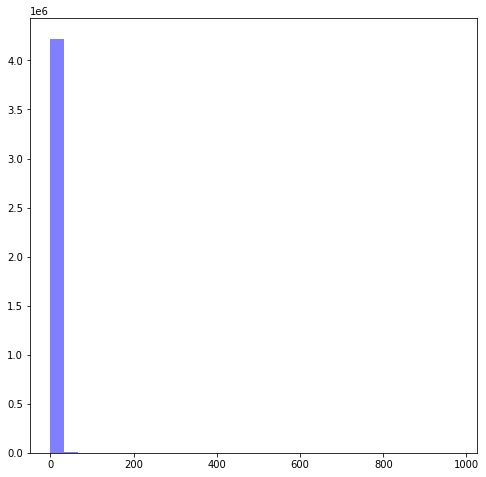

In [272]:
plt.figure(figsize=(8,8))
plt.hist(agg_email_cleaned_cleaned['TOP_LINE'], 30, facecolor='blue', alpha=0.5)

plt.show()

We an see zero inflation.  If we remove emails without sales, we get what looks like an exponential distribution

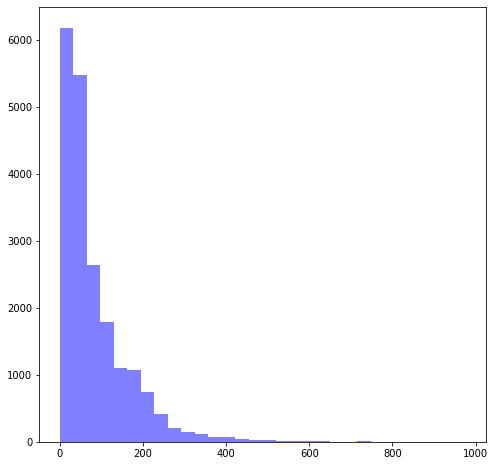

In [273]:
plt.figure(figsize=(8,8))
plt.hist(agg_email_cleaned_cleaned[agg_email_cleaned_cleaned['TOP_LINE']>0]['TOP_LINE'], 30, facecolor='blue', alpha=0.5)

plt.show()

Let's look at the log transform of the top line sales for customers that had positive top line

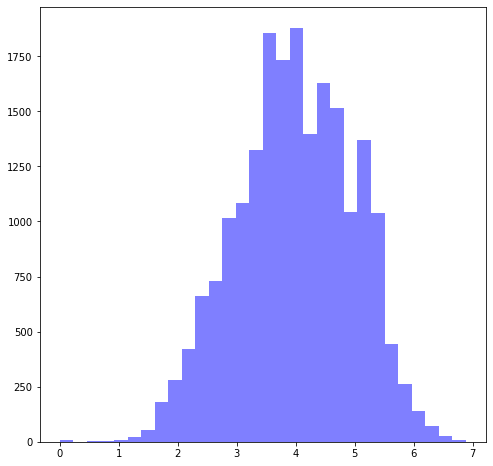

In [274]:
plt.figure(figsize=(8,8))
plt.hist(np.log(1+agg_email_cleaned_cleaned[agg_email_cleaned_cleaned['TOP_LINE']>0]['TOP_LINE']), 30, facecolor='blue', alpha=0.5)

plt.show()

Looks normalish.  Now lets test this for normality using the Kolmogorov-Smirnov test.  The null hypothesis is that the distribution is normally distributed

In [275]:
gt_zeros = agg_email_cleaned_cleaned[agg_email_cleaned_cleaned['TOP_LINE']>0]

In [276]:
len(gt_zeros)

20206

In [277]:
from statsmodels.stats.diagnostic import kstest_normal

In [278]:
gt_zeros['LOG_TOP_LINE'] = np.log(1+gt_zeros['TOP_LINE'])

In [279]:
kstest_normal(gt_zeros['LOG_TOP_LINE'], dist='norm', pvalmethod='table')

(0.025800221228838516, 0.0009999999999998899)

We can reject the null hypothesis that the disrtribution is normal and conclude it is not normal.  To keep things simple we will not use a log transform.  We now do a simple label change to establish the correct baselines for our regression analysis

In [280]:
gt_zeros['SENSITIVITY'] = np.where(gt_zeros.SENSITIVITY=='HIGH', 'high', 'LOW')

In [281]:
agg_email_cleaned_cleaned['SENSITIVITY'] = np.where(agg_email_cleaned_cleaned.SENSITIVITY=='HIGH', 'high', 'LOW')

We now try linear regression

In [282]:
from patsy import dmatrices
import statsmodels.api as sm

In [283]:
expr = 'TOP_LINE ~ SENSITIVITY  + DISCOUNT_CAT + DISCOUNT_CAT*SENSITIVITY'

In [284]:
y, X = dmatrices(expr, agg_email_cleaned_cleaned, return_type='dataframe')

In [285]:
X.head()

Intercept  SENSITIVITY[T.high]  DISCOUNT_CAT[T.20%]  \
0                1.000                1.000                0.000   
1                1.000                0.000                0.000   
2                1.000                1.000                0.000   
3                1.000                0.000                1.000   
4                1.000                0.000                0.000   

   DISCOUNT_CAT[T.25%]  DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]  \
0                0.000                                    0.000   
1                0.000                                    0.000   
2                0.000                                    0.000   
3                0.000                                    0.000   
4                1.000                                    0.000   

   DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]  
0                                    0.000  
1                                    0.000  
2                                    0.000  
3                                    0.000  
4                                    0.000

We ran multiples models and removed predictors that were not statistically significant.  Best practice is that you do not remove a primary predictor if it is part of an interaction feature, so we leave in DISCOUNT_CAT[T.20%]

In [286]:
linear_model = sm.OLS(y, X[['Intercept', 'SENSITIVITY[T.high]', 'DISCOUNT_CAT[T.20%]', 'DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]']])

In [287]:
linear_results = linear_model.fit()

In [288]:
linear_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TOP_LINE   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     101.4
Date:                Mon, 07 Mar 2022   Prob (F-statistic):           1.16e-65
Time:                        19:27:03   Log-Likelihood:            -1.4961e+07
No. Observations:             4236035   AIC:                         2.992e+07
Df Residuals:                 4236031   BIC:                         2.992e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.3747      0.005     73.556      0.000       0.365       0.385
SENSITIVITY[T.high]                         0.1969      0.015     12.867      0.000       0.167       0.227
DISCOUNT_CAT[T.20%]                        -0.0048      0.009     -0.519      0.604      -0.023       0.013
DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]     0.0779      0.028      2.791      0.005       0.023       0.133
==============================================================================
Omnibus:                 11540234.132   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     497031648292.955
Skew:                          34.081   Prob(JB):                         0.00
Kurtosis:                    1679.715   Cond. No.                         7.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We ignore DISCOUNT_CAT[T.20%].  Our baseline is all customers that are not discount sensitive.  The mean for customers with low discount senstivity is 37 cents per email address.  If a customer is highly dicount senstive (regardless of the discount offered), the mean is 57 cents.  If you were given a 20% coupon offer, the mean goes up to 65 cents.

Some notes on our results: An r-squared of zero indicates that the vast majority of the variance between observations is within each categorical group rather than between groups.  Also, Prob(Omnibus):0.000 indicates that the errors are not normally distributed.  However, Durbin-Watson: 1.999 indicates some homoskedacity.

At first this seems troubling regarding inference.  But we are not predicting a single observation; we are predicting the means of subsets of the population.  Via the central limit theorem, we can conclude that our confidence intervals of coefficients for predicitons of the means of groups is in fact statistically significant. 

We will now combine all highly discount senstive customers that were offered 20 and 25% and call those '20+%'

Now, let's combine the 20% abd 25% groups for highly discount senstive customers, since the means are not statistically different from each other.

In [290]:
agg_email_cleaned_cleaned['DISCOUNT_CAT'] = np.where(
    ((agg_email_cleaned_cleaned.SENSITIVITY=='high') & (
        agg_email_cleaned_cleaned.DISCOUNT_CAT.isin(['20%', '25%']))), '20%+', agg_email_cleaned_cleaned.DISCOUNT_CAT)

In [291]:
expr = 'TOP_LINE ~ SENSITIVITY  + DISCOUNT_CAT + DISCOUNT_CAT*SENSITIVITY'

In [292]:
y, X = dmatrices(expr, agg_email_cleaned_cleaned, return_type='dataframe')

In [293]:
X.head()

Intercept  SENSITIVITY[T.high]  DISCOUNT_CAT[T.20%]  \
0                1.000                1.000                0.000   
1                1.000                0.000                0.000   
2                1.000                1.000                0.000   
3                1.000                0.000                1.000   
4                1.000                0.000                0.000   

   DISCOUNT_CAT[T.20%+]  DISCOUNT_CAT[T.25%]  \
0                 0.000                0.000   
1                 0.000                0.000   
2                 0.000                0.000   
3                 0.000                0.000   
4                 0.000                1.000   

   DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]  \
0                                    0.000   
1                                    0.000   
2                                    0.000   
3                                    0.000   
4                                    0.000   

   DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]  \
0                                     0.000   
1                                     0.000   
2                                     0.000   
3                                     0.000   
4                                     0.000   

   DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]  
0                                    0.000  
1                                    0.000  
2                                    0.000  
3                                    0.000  
4                                    0.000

In [294]:
y.head()

TOP_LINE
0                0.000
1                0.000
2                0.000
3                0.000
4                0.000

In [295]:
linear_model = sm.OLS(y, X)

In [296]:
linear_results = linear_model.fit()

In [297]:
linear_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TOP_LINE   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     80.58
Date:                Mon, 07 Mar 2022   Prob (F-statistic):           1.65e-68
Time:                        19:28:35   Log-Likelihood:            -1.4961e+07
No. Observations:             4236035   AIC:                         2.992e+07
Df Residuals:                 4236030   BIC:                         2.992e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.3685      0.006     66.960      0.000       0.358       0.379
SENSITIVITY[T.high]                          0.1847      0.017     11.175      0.000       0.152       0.217
DISCOUNT_CAT[T.20%]                          0.0014      0.010      0.146      0.884      -0.017       0.020
DISCOUNT_CAT[T.20%+]                         0.0505      0.012      4.098      0.000       0.026       0.075
DISCOUNT_CAT[T.25%]                          0.0435      0.015      2.988      0.003       0.015       0.072
DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]           0          0        nan        nan           0           0
DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]     0.0505      0.012      4.098      0.000       0.026       0.075
DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]           0          0        nan        nan           0           0
==============================================================================
Omnibus:                 11540211.844   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     497022277891.451
Skew:                          34.081   Prob(JB):                         0.00
Kurtosis:                    1679.699   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We now only leave the significant predictors.  Note that DISCOUNT_CAT[T.20%+] and DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high] are always together, so we only keep one of these.

In [298]:
X.head()

Intercept  SENSITIVITY[T.high]  DISCOUNT_CAT[T.20%]  \
0                1.000                1.000                0.000   
1                1.000                0.000                0.000   
2                1.000                1.000                0.000   
3                1.000                0.000                1.000   
4                1.000                0.000                0.000   

   DISCOUNT_CAT[T.20%+]  DISCOUNT_CAT[T.25%]  \
0                 0.000                0.000   
1                 0.000                0.000   
2                 0.000                0.000   
3                 0.000                0.000   
4                 0.000                1.000   

   DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]  \
0                                    0.000   
1                                    0.000   
2                                    0.000   
3                                    0.000   
4                                    0.000   

   DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]  \
0                                     0.000   
1                                     0.000   
2                                     0.000   
3                                     0.000   
4                                     0.000   

   DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]  
0                                    0.000  
1                                    0.000  
2                                    0.000  
3                                    0.000  
4                                    0.000

In [299]:
linear_model = sm.OLS(y, X[['Intercept',
                            'SENSITIVITY[T.high]',
                            'DISCOUNT_CAT[T.25%]',
                            'DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]']])

In [300]:
linear_results = linear_model.fit()

In [301]:
linear_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TOP_LINE   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     107.4
Date:                Mon, 07 Mar 2022   Prob (F-statistic):           1.48e-69
Time:                        19:28:37   Log-Likelihood:            -1.4961e+07
No. Observations:             4236035   AIC:                         2.992e+07
Df Residuals:                 4236031   BIC:                         2.992e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.3690      0.004     82.104      0.000       0.360       0.378
SENSITIVITY[T.high]                          0.1842      0.016     11.359      0.000       0.152       0.216
DISCOUNT_CAT[T.25%]                          0.0430      0.014      3.030      0.002       0.015       0.071
DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]     0.1009      0.025      4.098      0.000       0.053       0.149
==============================================================================
Omnibus:                 11540211.476   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     497022132060.708
Skew:                          34.081   Prob(JB):                         0.00
Kurtosis:                    1679.699   Cond. No.                         6.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Now we model margin

In [302]:
expr = 'POS_GROSS_MARGIN ~ SENSITIVITY  + DISCOUNT_CAT + DISCOUNT_CAT*SENSITIVITY'

In [303]:
y, X = dmatrices(expr, agg_email_cleaned_cleaned, return_type='dataframe')

In [304]:
X.head()

Intercept  SENSITIVITY[T.high]  DISCOUNT_CAT[T.20%]  \
0                1.000                1.000                0.000   
1                1.000                0.000                0.000   
2                1.000                1.000                0.000   
3                1.000                0.000                1.000   
4                1.000                0.000                0.000   

   DISCOUNT_CAT[T.20%+]  DISCOUNT_CAT[T.25%]  \
0                 0.000                0.000   
1                 0.000                0.000   
2                 0.000                0.000   
3                 0.000                0.000   
4                 0.000                1.000   

   DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]  \
0                                    0.000   
1                                    0.000   
2                                    0.000   
3                                    0.000   
4                                    0.000   

   DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]  \
0                                     0.000   
1                                     0.000   
2                                     0.000   
3                                     0.000   
4                                     0.000   

   DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]  
0                                    0.000  
1                                    0.000  
2                                    0.000  
3                                    0.000  
4                                    0.000

In [305]:
linear_model_gm = sm.OLS(y, X[['Intercept',
                            'SENSITIVITY[T.high]',
                            'DISCOUNT_CAT[T.25%]',
                            'DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]']])

In [306]:
linear_results_gm = linear_model_gm.fit()

In [307]:
linear_results_gm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       POS_GROSS_MARGIN   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     87.08
Date:                Mon, 07 Mar 2022   Prob (F-statistic):           2.45e-56
Time:                        19:29:01   Log-Likelihood:            -1.2863e+07
No. Observations:             4236035   AIC:                         2.573e+07
Df Residuals:                 4236031   BIC:                         2.573e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.2195      0.003     80.143      0.000       0.214       0.225
SENSITIVITY[T.high]                          0.1028      0.010     10.403      0.000       0.083       0.122
DISCOUNT_CAT[T.25%]                          0.0207      0.009      2.390      0.017       0.004       0.038
DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]     0.0523      0.015      3.483      0.000       0.023       0.082
==============================================================================
Omnibus:                 11712668.814   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     576217038563.032
Skew:                          35.417   Prob(JB):                         0.00
Kurtosis:                    1808.448   Cond. No.                         6.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### We now have two linear models, one for top line and one for gross margin.  We will now create a prediction dataframe representing the baseline --- meaning everyone gets a 15% discount

In [308]:
agg_email_cleaned_cleaned.head()

EMAIL_ADDRESS DISCOUNT_CAT SENSITIVITY                SCORE  \
0         0.0nhanson@gmail.com          15%        high                0.968   
1        0.5bbloffcntr@att.net          15%         LOW                0.047   
2           0.5full2@gmail.com          15%        high                0.985   
3        0.susanhall@gmail.com          20%         LOW                0.016   
4  00.hernandez.ivan@gmail.com          25%         LOW                0.035   

              TOP_LINE     POS_GROSS_MARGIN  
0                0.000                0.000  
1                0.000                0.000  
2                0.000                0.000  
3                0.000                0.000  
4                0.000                0.000

In [309]:
baseline = agg_email_cleaned_cleaned.copy()

In [310]:
baseline.head()

EMAIL_ADDRESS DISCOUNT_CAT SENSITIVITY                SCORE  \
0         0.0nhanson@gmail.com          15%        high                0.968   
1        0.5bbloffcntr@att.net          15%         LOW                0.047   
2           0.5full2@gmail.com          15%        high                0.985   
3        0.susanhall@gmail.com          20%         LOW                0.016   
4  00.hernandez.ivan@gmail.com          25%         LOW                0.035   

              TOP_LINE     POS_GROSS_MARGIN  
0                0.000                0.000  
1                0.000                0.000  
2                0.000                0.000  
3                0.000                0.000  
4                0.000                0.000

In [311]:
expr = 'TOP_LINE ~ SENSITIVITY  + DISCOUNT_CAT + DISCOUNT_CAT*SENSITIVITY'

In [312]:
y, X = dmatrices(expr, baseline, return_type='dataframe')

In [313]:
X.head()

Intercept  SENSITIVITY[T.high]  DISCOUNT_CAT[T.20%]  \
0                1.000                1.000                0.000   
1                1.000                0.000                0.000   
2                1.000                1.000                0.000   
3                1.000                0.000                1.000   
4                1.000                0.000                0.000   

   DISCOUNT_CAT[T.20%+]  DISCOUNT_CAT[T.25%]  \
0                 0.000                0.000   
1                 0.000                0.000   
2                 0.000                0.000   
3                 0.000                0.000   
4                 0.000                1.000   

   DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]  \
0                                    0.000   
1                                    0.000   
2                                    0.000   
3                                    0.000   
4                                    0.000   

   DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]  \
0                                     0.000   
1                                     0.000   
2                                     0.000   
3                                     0.000   
4                                     0.000   

   DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]  
0                                    0.000  
1                                    0.000  
2                                    0.000  
3                                    0.000  
4                                    0.000

In [314]:
y.head()

TOP_LINE
0                0.000
1                0.000
2                0.000
3                0.000
4                0.000

In [315]:
cols = X.columns

In [316]:
cols_to_zero = cols[2:]

In [317]:
X.head()

Intercept  SENSITIVITY[T.high]  DISCOUNT_CAT[T.20%]  \
0                1.000                1.000                0.000   
1                1.000                0.000                0.000   
2                1.000                1.000                0.000   
3                1.000                0.000                1.000   
4                1.000                0.000                0.000   

   DISCOUNT_CAT[T.20%+]  DISCOUNT_CAT[T.25%]  \
0                 0.000                0.000   
1                 0.000                0.000   
2                 0.000                0.000   
3                 0.000                0.000   
4                 0.000                1.000   

   DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]  \
0                                    0.000   
1                                    0.000   
2                                    0.000   
3                                    0.000   
4                                    0.000   

   DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]  \
0                                     0.000   
1                                     0.000   
2                                     0.000   
3                                     0.000   
4                                     0.000   

   DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]  
0                                    0.000  
1                                    0.000  
2                                    0.000  
3                                    0.000  
4                                    0.000

In [318]:
for col in cols_to_zero:
    X[col] = 0.0

In [319]:
X = X[['Intercept', 'SENSITIVITY[T.high]', 'DISCOUNT_CAT[T.25%]', 'DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]']]

In [320]:
baseline_topline_predictions = linear_results.get_prediction(X)

In [321]:
baseline_topline_predictions.predicted_mean.sum()

1649594.8399356173

In [322]:
baseline_margin_prediction = linear_results_gm.get_prediction(X)

In [323]:
baseline_margin_prediction.predicted_mean.sum()

977987.5806563728

In [324]:
baseline_margin_prediction.predicted_mean.sum()/baseline_topline_predictions.predicted_mean.sum()

0.5928653248542795

The baseline margin is 59.29%

Actual predictions from actual data

In [325]:
expr = 'TOP_LINE ~ SENSITIVITY  + DISCOUNT_CAT + DISCOUNT_CAT*SENSITIVITY'

In [326]:
y, X = dmatrices(expr, agg_email_cleaned_cleaned, return_type='dataframe')

In [327]:
X.head()

Intercept  SENSITIVITY[T.high]  DISCOUNT_CAT[T.20%]  \
0                1.000                1.000                0.000   
1                1.000                0.000                0.000   
2                1.000                1.000                0.000   
3                1.000                0.000                1.000   
4                1.000                0.000                0.000   

   DISCOUNT_CAT[T.20%+]  DISCOUNT_CAT[T.25%]  \
0                 0.000                0.000   
1                 0.000                0.000   
2                 0.000                0.000   
3                 0.000                0.000   
4                 0.000                1.000   

   DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]  \
0                                    0.000   
1                                    0.000   
2                                    0.000   
3                                    0.000   
4                                    0.000   

   DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]  \
0                                     0.000   
1                                     0.000   
2                                     0.000   
3                                     0.000   
4                                     0.000   

   DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]  
0                                    0.000  
1                                    0.000  
2                                    0.000  
3                                    0.000  
4                                    0.000

In [328]:
y.head()

TOP_LINE
0                0.000
1                0.000
2                0.000
3                0.000
4                0.000

In [329]:
X = X[['Intercept', 'SENSITIVITY[T.high]', 'DISCOUNT_CAT[T.25%]', 'DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]']]

In [330]:
test_topline_predictions = linear_results.get_prediction(X)

In [331]:
test_topline_predictions.predicted_mean.sum()

1684814.000000001

In [332]:
test_margin_prediction = linear_results_gm.get_prediction(X)

In [333]:
test_margin_prediction.predicted_mean.sum()

995625.0700000026

In [334]:
test_margin_prediction.predicted_mean.sum()/test_topline_predictions.predicted_mean.sum()

0.5909406438930364

The test margin is 59.10%.  Top line goes up and margin goes down as expected

### Now we set things up to give all our highly discount sensitive customers >= 20% discount

In [335]:
twenty = agg_email_cleaned_cleaned.copy()

In [336]:
twenty.head()

EMAIL_ADDRESS DISCOUNT_CAT SENSITIVITY                SCORE  \
0         0.0nhanson@gmail.com          15%        high                0.968   
1        0.5bbloffcntr@att.net          15%         LOW                0.047   
2           0.5full2@gmail.com          15%        high                0.985   
3        0.susanhall@gmail.com          20%         LOW                0.016   
4  00.hernandez.ivan@gmail.com          25%         LOW                0.035   

              TOP_LINE     POS_GROSS_MARGIN  
0                0.000                0.000  
1                0.000                0.000  
2                0.000                0.000  
3                0.000                0.000  
4                0.000                0.000

In [337]:
expr = 'TOP_LINE ~ SENSITIVITY  + DISCOUNT_CAT + DISCOUNT_CAT*SENSITIVITY'

In [338]:
y, X = dmatrices(expr, twenty, return_type='dataframe')

In [339]:
X.head()

Intercept  SENSITIVITY[T.high]  DISCOUNT_CAT[T.20%]  \
0                1.000                1.000                0.000   
1                1.000                0.000                0.000   
2                1.000                1.000                0.000   
3                1.000                0.000                1.000   
4                1.000                0.000                0.000   

   DISCOUNT_CAT[T.20%+]  DISCOUNT_CAT[T.25%]  \
0                 0.000                0.000   
1                 0.000                0.000   
2                 0.000                0.000   
3                 0.000                0.000   
4                 0.000                1.000   

   DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]  \
0                                    0.000   
1                                    0.000   
2                                    0.000   
3                                    0.000   
4                                    0.000   

   DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]  \
0                                     0.000   
1                                     0.000   
2                                     0.000   
3                                     0.000   
4                                     0.000   

   DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]  
0                                    0.000  
1                                    0.000  
2                                    0.000  
3                                    0.000  
4                                    0.000

In [340]:
cols = X.columns

In [341]:
cols

Index(['Intercept', 'SENSITIVITY[T.high]', 'DISCOUNT_CAT[T.20%]',
       'DISCOUNT_CAT[T.20%+]', 'DISCOUNT_CAT[T.25%]',
       'DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]',
       'DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]',
       'DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]'],
      dtype='object')

In [342]:
cols_to_zero = cols[2:]

In [343]:
for col in cols_to_zero:
    X[col] = 0.0

Now we need to set the 'DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]' to 1.0 for all rows where 'SENSITIVITY[T.high]' == 1.0

In [345]:
X.head()

Intercept  SENSITIVITY[T.high]  DISCOUNT_CAT[T.20%]  \
0                1.000                1.000                0.000   
1                1.000                0.000                0.000   
2                1.000                1.000                0.000   
3                1.000                0.000                0.000   
4                1.000                0.000                0.000   

   DISCOUNT_CAT[T.20%+]  DISCOUNT_CAT[T.25%]  \
0                 0.000                0.000   
1                 0.000                0.000   
2                 0.000                0.000   
3                 0.000                0.000   
4                 0.000                0.000   

   DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]  \
0                                    0.000   
1                                    0.000   
2                                    0.000   
3                                    0.000   
4                                    0.000   

   DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]  \
0                                     0.000   
1                                     0.000   
2                                     0.000   
3                                     0.000   
4                                     0.000   

   DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]  
0                                    0.000  
1                                    0.000  
2                                    0.000  
3                                    0.000  
4                                    0.000

In [346]:
X['DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]'] = np.where(X['SENSITIVITY[T.high]'] > 0.9, 1.0, 0.0)

In [347]:
X = X[['Intercept', 'SENSITIVITY[T.high]', 'DISCOUNT_CAT[T.25%]', 'DISCOUNT_CAT[T.20%+]:SENSITIVITY[T.high]']]

In [348]:
twenty_topline_predictions = linear_results.get_prediction(X)

In [349]:
twenty_topline_predictions.predicted_mean.sum()

1697024.3875936687

In [350]:
twenty_margin_prediction = linear_results_gm.get_prediction(X)

In [351]:
twenty_margin_prediction.predicted_mean.sum()

1002553.4198192555

In [352]:
twenty_margin_prediction.predicted_mean.sum()/twenty_topline_predictions.predicted_mean.sum()

0.5907713684897876

In [353]:
(1697024.3875936687 - 1649594.8399356173)

47429.547658051364

In [354]:
47429.547658051364 * 52

2466336.478218671

Now we create a function to calculate weekly top line and gross margin

In [355]:
agg_email_cleaned_cleaned.head()

EMAIL_ADDRESS DISCOUNT_CAT SENSITIVITY                SCORE  \
0         0.0nhanson@gmail.com          15%        high                0.968   
1        0.5bbloffcntr@att.net          15%         LOW                0.047   
2           0.5full2@gmail.com          15%        high                0.985   
3        0.susanhall@gmail.com          20%         LOW                0.016   
4  00.hernandez.ivan@gmail.com          25%         LOW                0.035   

              TOP_LINE     POS_GROSS_MARGIN  
0                0.000                0.000  
1                0.000                0.000  
2                0.000                0.000  
3                0.000                0.000  
4                0.000                0.000